# Chapter 2 Exercises

In [1]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
seasons = range(2016, 2023 + 1)
pbp = nfl.import_pbp_data(seasons)

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


In [3]:
# filter to only passing plays
pbp_p = pbp.query("play_type == 'pass' & air_yards.notnull()").reset_index()

In [4]:
# short pass < 20 air yards
# long pass >= 20 air yards
pbp_p["pass_length_air_yards"] = np.where(pbp_p["air_yards"] >= 20, "long", "short")

# replace incomplete passing yards (from Null to 0)
pbp_p["passing_yards"] = np.where(pbp_p["passing_yards"].isnull(), 0, pbp_p["passing_yards"])

In [5]:
# create df for short & long
pbp_p_short = pbp_p.query('pass_length_air_yards == "short"')
pbp_p_long = pbp_p.query('pass_length_air_yards == "long"')

### 1) Create the same histograms but for EPA per pass attempt.

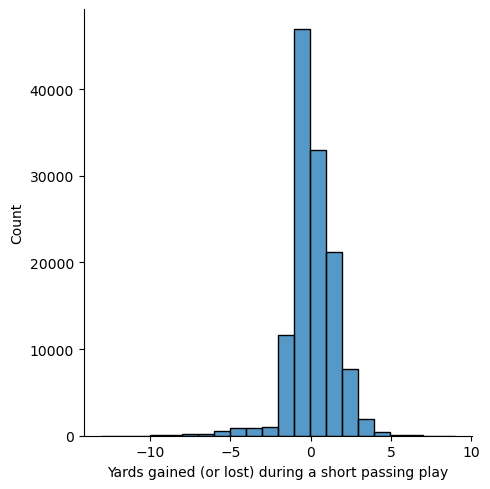

In [6]:
pbp_p_hist_short = sns.displot(data=pbp_p_short, binwidth=1,
                             x="epa")
pbp_p_hist_short.set_axis_labels(
    "Yards gained (or lost) during a short passing play", "Count")
plt.show()

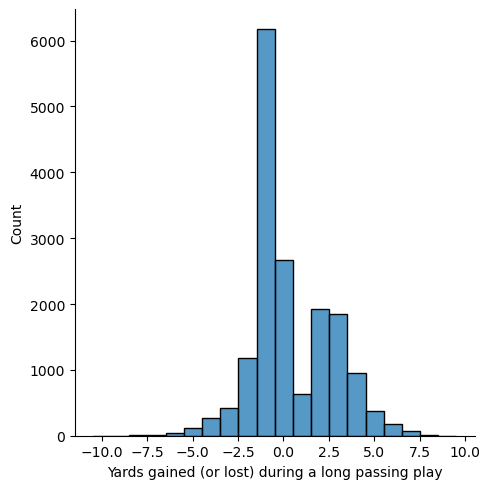

In [7]:
pbp_p_hist_long = sns.displot(data=pbp_p_long, binwidth=1,
                             x="epa")
pbp_p_hist_long.set_axis_labels(
    "Yards gained (or lost) during a long passing play", "Count")
plt.show()

### 2) Create the same boxplots but for EPA per pass attempt.

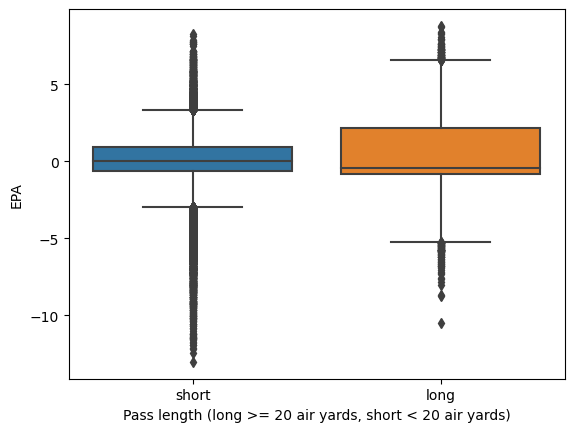

In [8]:
epa_boxplot = sns.boxplot(data=pbp_p, x="pass_length_air_yards", y="epa")

epa_boxplot.set(xlabel="Pass length (long >= 20 air yards, short < 20 air yards)",
               ylabel="EPA")
plt.show()

### 3) Perform the same stability analysis but for EPA per pass attempt.
- Do you see the same qualitative results as when you use YPA?
- Do any players have similar YPA numbers one year to the next but have drastically different EPA per pass attempt numbers across years?
- Where could these differences come from?


In [9]:
# aggregate data by player, season & short/long pass type
pbp_p_s = pbp_p.groupby(["passer_id", "passer", "season", "pass_length_air_yards"]).agg({"epa": ["mean", "count"]})

# collapse columns
pbp_p_s.columns = list(map("_".join, pbp_p_s.columns.values))

# rename columns
pbp_p_s.rename(columns={'epa_mean': 'epa_per_pass', 'epa_count': 'n'}, inplace=True)

# reset index
pbp_p_s.reset_index(inplace=True)

In [10]:
pbp_p_s.head()

,passer_id,passer,season,pass_length_air_yards,epa_per_pass,n
0,00-0019596,T.Brady,2016,long,0.968524,69
1,00-0019596,T.Brady,2016,short,0.259909,503
2,00-0019596,T.Brady,2017,long,0.608399,102
3,00-0019596,T.Brady,2017,short,0.311320,616
4,00-0019596,T.Brady,2018,long,0.204391,73


In [11]:
# remove < 100 short passes in season
# remove < 30 long passes in season
q_value = ('(n >= 100 & ' + 'pass_length_air_yards == "short") | ' +
           '(n >= 30 & ' + 'pass_length_air_yards == "long")'
          )

pbp_p_s = pbp_p_s.query(q_value).reset_index()

In [12]:
# copy df to create lag
pbp_p_s_lag = pbp_p_s.copy()

# take the current season value and add 1 using +=
pbp_p_s_lag["season"] += 1

# rename epa_per_pass to include lag
pbp_p_s_lag.rename(columns={"epa_per_pass": "epa_per_pass_last"}, inplace=True)

In [13]:
pbp_p_s_lag.head()

,index,passer_id,passer,season,pass_length_air_yards,epa_per_pass_last,n
0,0,00-0019596,T.Brady,2017,long,0.968524,69
1,1,00-0019596,T.Brady,2017,short,0.259909,503
2,2,00-0019596,T.Brady,2018,long,0.608399,102
3,3,00-0019596,T.Brady,2018,short,0.311320,616
4,4,00-0019596,T.Brady,2019,long,0.204391,73


In [14]:
# merge the two df to bring epa_per_pass_last over using inner join so only shared years are included
# join on passer_id, passer, season & pass_length_air_yards
final_df = pbp_p_s.merge(pbp_p_s_lag, how='inner', on=["passer_id", "passer", "season", "pass_length_air_yards"])

In [15]:
final_df.head()

,index_x,passer_id,passer,season,pass_length_air_yards,epa_per_pass,n_x,index_y,epa_per_pass_last,n_y
0,2,00-0019596,T.Brady,2017,long,0.608399,102,0,0.968524,69
1,3,00-0019596,T.Brady,2017,short,0.311320,616,1,0.259909,503
2,4,00-0019596,T.Brady,2018,long,0.204391,73,2,0.608399,102
3,5,00-0019596,T.Brady,2018,short,0.219365,620,3,0.311320,616
4,6,00-0019596,T.Brady,2019,long,0.424035,70,4,0.204391,73


In [16]:
final_df = final_df.drop(columns=['index_x', 'index_y'])
final_df = final_df.rename(columns={'n_x': 'n', 'n_y': 'n_last'})
final_df.head()

,passer_id,passer,season,pass_length_air_yards,epa_per_pass,n,epa_per_pass_last,n_last
0,00-0019596,T.Brady,2017,long,0.608399,102,0.968524,69
1,00-0019596,T.Brady,2017,short,0.311320,616,0.259909,503
2,00-0019596,T.Brady,2018,long,0.204391,73,0.608399,102
3,00-0019596,T.Brady,2018,short,0.219365,620,0.311320,616
4,00-0019596,T.Brady,2019,long,0.424035,70,0.204391,73


In [17]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 360 entries, 0 to 359
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   passer_id              360 non-null    object 
 1   passer                 360 non-null    object 
 2   season                 360 non-null    int64  
 3   pass_length_air_yards  360 non-null    object 
 4   epa_per_pass           360 non-null    float32
 5   n                      360 non-null    int64  
 6   epa_per_pass_last      360 non-null    float32
 7   n_last                 360 non-null    int64  
dtypes: float32(2), int64(3), object(3)
memory usage: 22.5+ KB


In [18]:
# how many unique passers?
len(final_df.passer_id.unique())

69

<Axes: xlabel='epa_per_pass', ylabel='epa_per_pass_last'>

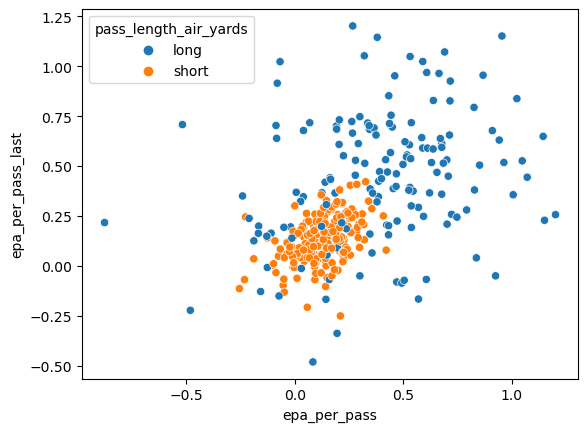

In [19]:
sns.scatterplot(data=final_df, x='epa_per_pass', y='epa_per_pass_last', hue='pass_length_air_yards')

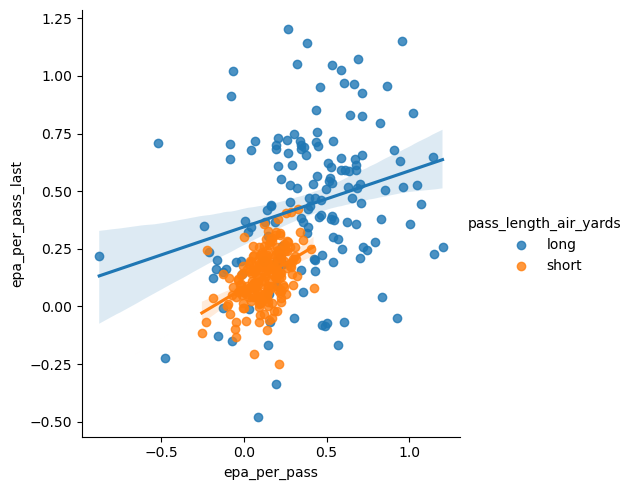

In [20]:
sns.lmplot(data=final_df, x='epa_per_pass', y='epa_per_pass_last', hue='pass_length_air_yards')

In [21]:
# correlation
final_df.query("epa_per_pass.notnull() & epa_per_pass_last.notnull()")\
                .groupby("pass_length_air_yards")[["epa_per_pass", "epa_per_pass_last"]].corr()

epa_per_pass  epa_per_pass_last
pass_length_air_yards                                                   
long                  epa_per_pass           1.000000           0.261617
                      epa_per_pass_last      0.261617           1.000000
short                 epa_per_pass           1.000000           0.432527
                      epa_per_pass_last      0.432527           1.000000

In [22]:
# 2023 leaderboard for deep passing epa_per_pass
final_df.query('pass_length_air_yards == "long" & season == 2023')\
                    [["passer_id", "passer", "epa_per_pass", "n"]]\
                    .sort_values(["epa_per_pass"], ascending=False).head(32)

,passer_id,passer,epa_per_pass,n
346,00-0036971,T.Lawrence,1.006918,40
224,00-0033077,D.Prescott,0.942645,49
320,00-0036212,T.Tagovailoa,0.868031,41
91,00-0026498,M.Stafford,0.837137,39
331,00-0036389,J.Hurts,0.677674,47
158,00-0030565,G.Smith,0.537355,42
237,00-0033106,J.Goff,0.534596,34
128,00-0029263,R.Wilson,0.498949,43
326,00-0036355,J.Herbert,0.399671,51
291,00-0034857,J.Allen,0.165246,55


In [23]:
# 2023 leaderboard for deep passing epa_per_pass
final_df.query('pass_length_air_yards == "short" & season == 2023')\
                    [["passer_id", "passer", "epa_per_pass", "n"]]\
                    .sort_values(["epa_per_pass"], ascending=False).head(32)

,passer_id,passer,epa_per_pass,n
356,00-0037834,B.Purdy,0.340285,266
321,00-0036212,T.Tagovailoa,0.216056,334
292,00-0034857,J.Allen,0.206297,377
225,00-0033077,D.Prescott,0.205530,321
263,00-0033873,P.Mahomes,0.190423,368
274,00-0034796,L.Jackson,0.188496,293
327,00-0036355,J.Herbert,0.146623,351
338,00-0036442,J.Burrow,0.140169,332
238,00-0033106,J.Goff,0.137121,370
332,00-0036389,J.Hurts,0.135294,311


In [24]:
# Mahomes season by season
print(final_df[["pass_length_air_yards", "passer", "season", "epa_per_pass", "epa_per_pass_last"]]\
                    .query('passer == "P.Mahomes"')\
                    .sort_values(["passer", "pass_length_air_yards", "season"])\
                    .to_string()
)

    pass_length_air_yards     passer  season  epa_per_pass  epa_per_pass_last
254                  long  P.Mahomes    2019      1.144922           0.648732
256                  long  P.Mahomes    2020      0.380278           1.144922
258                  long  P.Mahomes    2021      0.828491           0.380278
260                  long  P.Mahomes    2022      0.638876           0.828491
262                  long  P.Mahomes    2023     -0.083336           0.638876
255                 short  P.Mahomes    2019      0.207115           0.380629
257                 short  P.Mahomes    2020      0.317622           0.207115
259                 short  P.Mahomes    2021      0.219632           0.317622
261                 short  P.Mahomes    2022      0.309379           0.219632
263                 short  P.Mahomes    2023      0.190423           0.309379


Create index against yearly epa environment?

4) One of the reasons that data for long pass attempts is less stable than short pass attempts is that there are fewer of them, which is largely a product of 20 yards being an arbitrary cutoff for long passes. Find a cutoff that equally splits the data and perform the same analysis. Do the results stay the same?

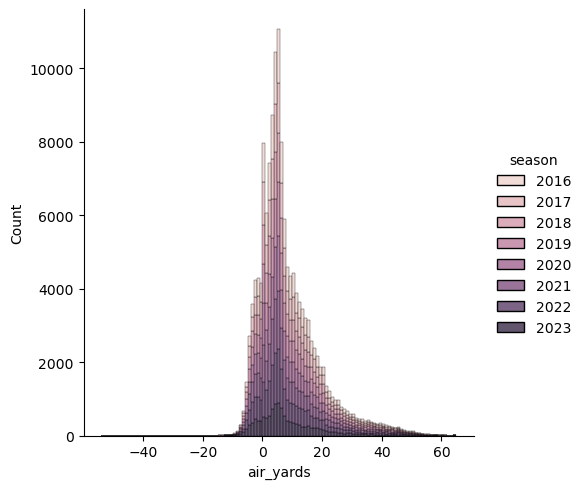

In [25]:
# find midpoint for air_yards
sns.displot(data=pbp_p, binwidth=1,
                             x="air_yards", hue="season", multiple="stack")
pbp_p_hist_short.set_axis_labels(
    "Yards gained (or lost) during a short passing play", "Count")
plt.show()

In [34]:
for year in pbp_p["season"].unique():
    print(year)
    print(pbp_p.query(f'season == {year}')["air_yards"].describe())

2016
count    19039.000000
mean         8.388885
std          9.932709
min        -14.000000
25%          2.000000
50%          6.000000
75%         13.000000
max         61.000000
Name: air_yards, dtype: float64
2017
count    18272.000000
mean         8.330615
std         10.210914
min        -15.000000
25%          2.000000
50%          6.000000
75%         13.000000
max         61.000000
Name: air_yards, dtype: float64
2018
count    18406.000000
mean         8.160708
std         10.146242
min        -15.000000
25%          2.000000
50%          5.000000
75%         13.000000
max         60.000000
Name: air_yards, dtype: float64
2019
count    18477.000000
mean         8.258267
std         10.193716
min        -19.000000
25%          2.000000
50%          5.000000
75%         13.000000
max         63.000000
Name: air_yards, dtype: float64
2020
count    18892.000000
mean         7.938651
std          9.987585
min        -13.000000
25%          1.000000
50%          5.000000
75%        

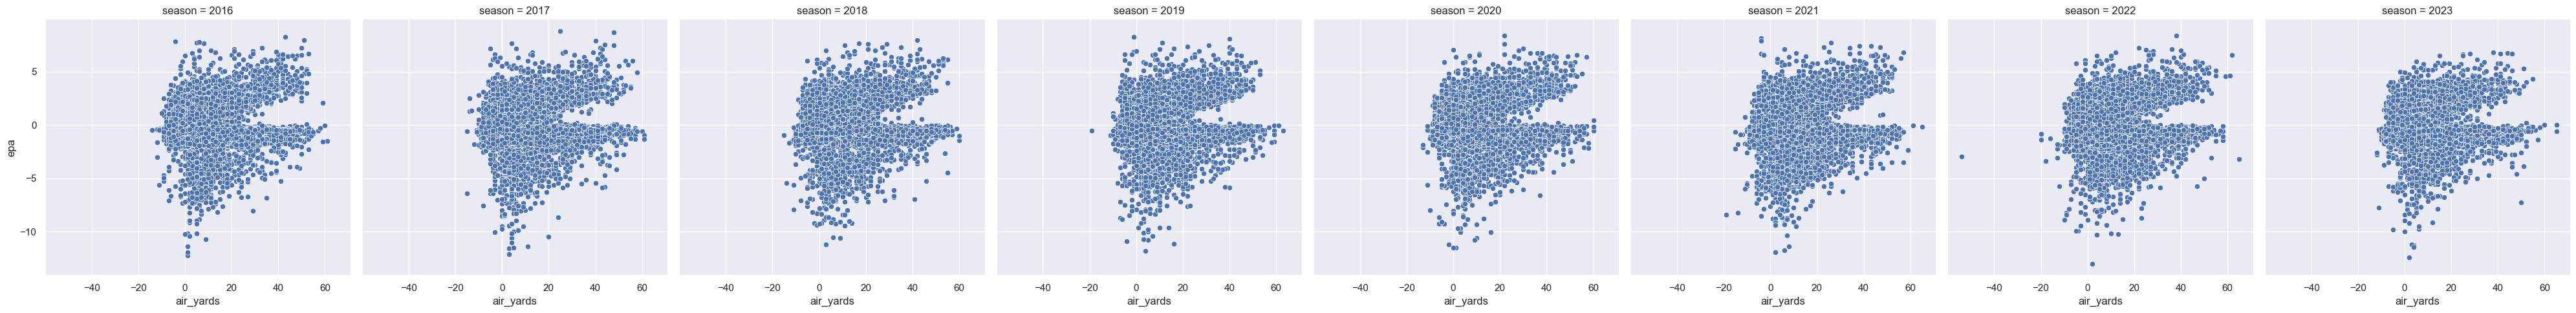

In [41]:
#sns.scatterplot(data=pbp_p, x="air_yards", y="epa", col="season")
sns.set(rc={'figure.figsize':(20,20)})
sns.relplot(data=pbp_p, x="air_yards", y="epa", col="season", kind="scatter")

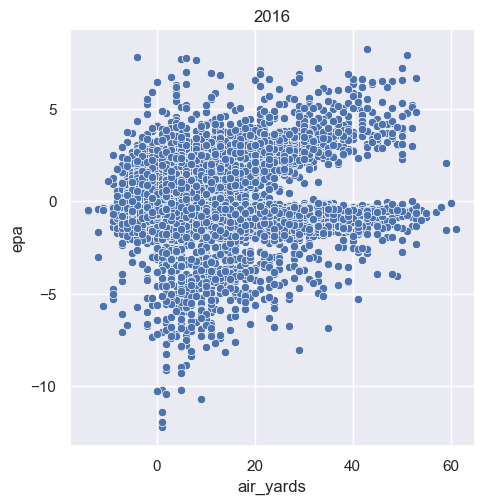

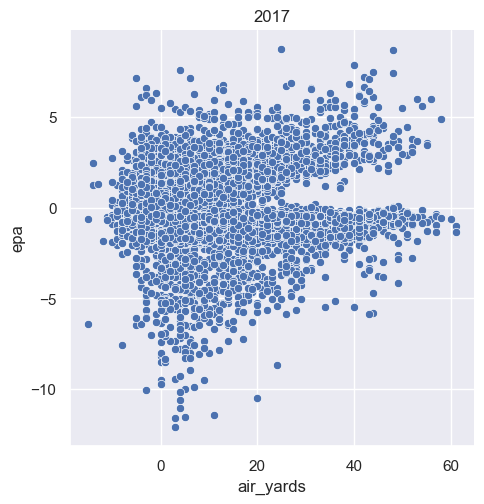

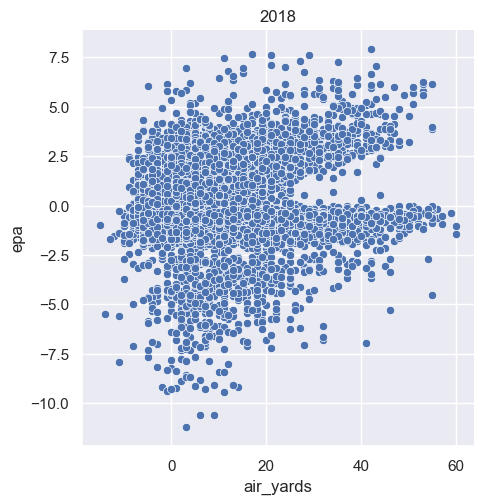

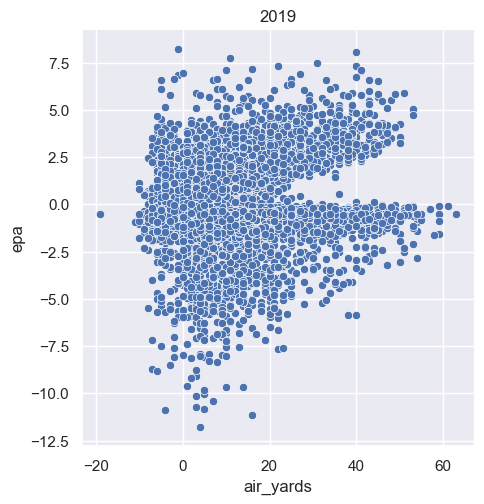

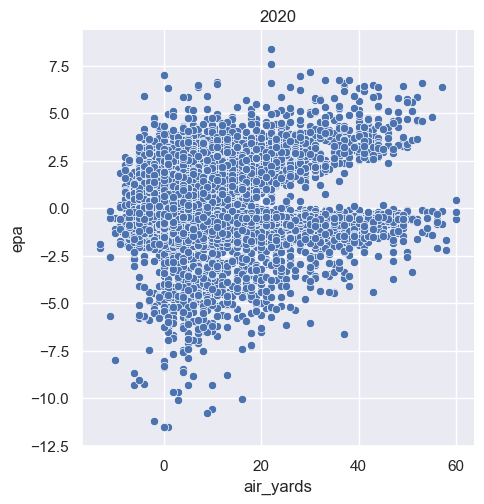

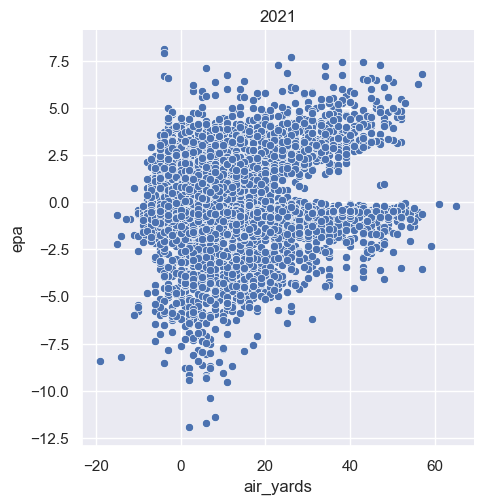

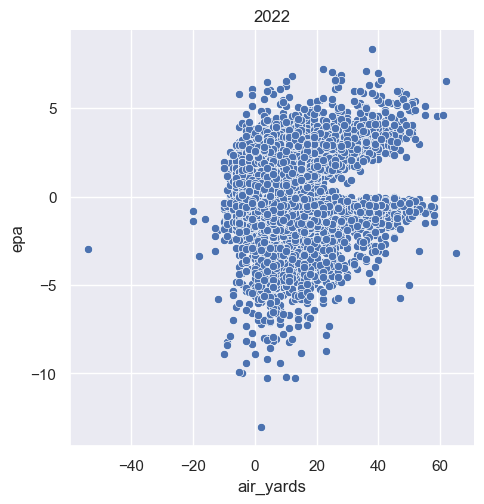

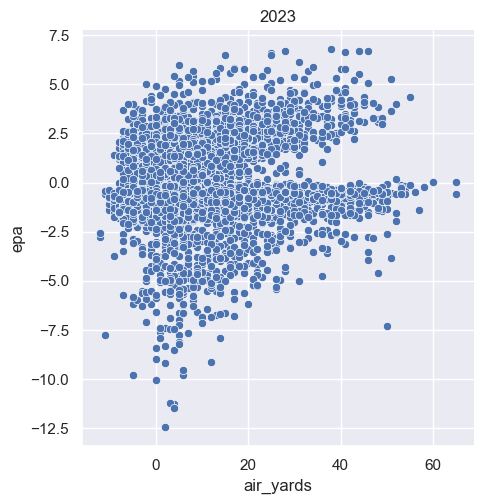

In [44]:
for year in pbp_p["season"].unique():
    data = pbp_p.query(f'season == {year}')
    sns.relplot(data=data, x="air_yards", y="epa", kind="scatter").set(title=year)